In [ ]:
#Required Packages
using Statistics
using Distributions
using QuadGK
using StatsBase
using KernelDensity
using Interpolations
using Random

using Optim
using ForwardDiff
using LinearAlgebra
using ARCHModels
using GLM
using HypothesisTests

using Plots
using DataFrames
using PlotThemes

using CSV
using Dates

using Printf
using LaTeXStrings

#Importing self-made functions
include("functions/LaTexTools.jl")
include("functions/llik_fun_GARCH_pq.jl")
include("functions/Hess_fun_GARCH.jl")
include("functions/fractional_moments.jl")
include("functions/simulate_conditional_variance.jl")
include("functions/log_likelihood.jl")
include("functions/beta_path.jl")
include("functions/compute_z.jl")
include("functions/simulate_conditional_return.jl")
include("functions/winsorize!.jl")
include("functions/Hess_fun_beta.jl")

using .LaTexTools
using .FractionalMoments

In [2]:
#Importing data
df = CSV.read("data/s_p_500_index.csv", DataFrame)

#Add/Change column (names)
rename!(df, "caldt" => "Date", "spindx" => "Level")
df.Date = Date.(df.Date, dateformat"mm/dd/yyyy")
df.Week = Dates.week.(df.Date)
df.Year = year.(df.Date)
df.Year_Week = string.(df.Year, "-", df.Week)

#Create Dataframe for weekly index instead of daily
df_weekly = combine(groupby(df, :Year_Week)) do subdf
    last_row = subdf[argmax(subdf.Date), :]
    return (Date=last_row.Date, Level=last_row.Level)
end

sort!(df_weekly, :Date)

#Defining (log) returns of stocks
df_weekly.log_return = [missing; 100 * diff(log.(df_weekly.Level))]
df_weekly = dropmissing(df_weekly, :log_return)
df_weekly.squared_returns = df_weekly.log_return .^ 2

df_weekly

Row,Year_Week,Date,Level,log_return,squared_returns
,String,Date,Float64,Float64,Float64
1,2000-2,2000-01-14,1465.15,1.62942,2.65501
2,2000-3,2000-01-21,1441.36,-1.63705,2.67994
3,2000-4,2000-01-28,1360.16,-5.79848,33.6223
4,2000-5,2000-02-04,1424.37,4.61273,21.2773
5,2000-6,2000-02-11,1387.12,-2.65,7.02248
6,2000-7,2000-02-18,1346.09,-3.00256,9.01534
7,2000-8,2000-02-25,1333.36,-0.950202,0.902884
8,2000-9,2000-03-03,1409.17,5.52988,30.5796
9,2000-10,2000-03-10,1395.07,-1.00563,1.01129


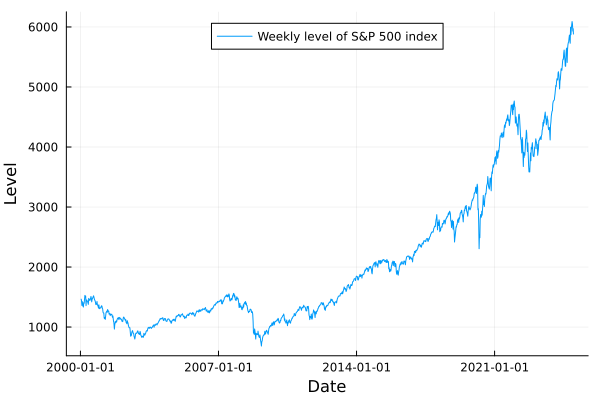

In [3]:
#Plotting stock level along the Dates (Clearly non-Stationary)
plt = plot(df_weekly.Date, df_weekly.Level,
    label="Weekly level of S&P 500 index", xlabel="Date", ylabel="Level",
    legend=:top)
display(plt)
#savefig(plt, "latex_project/figures/stock_level.pdf")

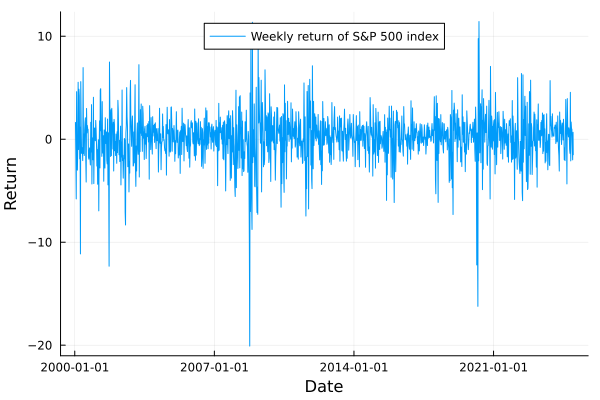

In [4]:
#Plotting (log) returns along Dates (Stationary)
plt = plot(df_weekly.Date, df_weekly.log_return,
    label="Weekly return of S&P 500 index", xlabel="Date", ylabel="Return",
    legend=:top)

display(plt)
#savefig(plt, "latex_project/figures/stock_returns.pdf")

In [15]:
result = ADFTest(df_weekly.log_return, :constant, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.02128

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          1301
    number of lags:                     1
    ADF statistic:                      -25.2266
    Critical values at 1%, 5%, and 10%: [-3.43538 -2.86376 -2.56795]


In [3]:
stat_df = DataFrame(
    Mean=Float64[],
    Variance=Float64[],
    Skewness=Float64[],
    Kurtosis=Float64[]
)

data_mean, variance, data_skewness, data_kurtosis = mean(df_weekly.log_return), var(df_weekly.log_return), skewness(df_weekly.log_return), kurtosis(df_weekly.log_return)
push!(stat_df, (data_mean, variance, data_skewness, data_kurtosis))
stat_df .= round.(stat_df, digits=3)
stat_df
#save_latex_table(stat_df, "Summary Statistics", "tables/stocks_statistics_table")

Row,Mean,Variance,Skewness,Kurtosis
,Float64,Float64,Float64,Float64
1,0.108,6.17,-0.878,7.225


In [ ]:
lags = 1:25
acf = autocor(df_weekly.squared_returns, lags)
confidence_bound = 1.96 / sqrt(length(df_weekly.squared_returns))
plt = bar(lags, acf, legend=false, title="ACF of Squared Returns", xlabel="Lag",
    ylabel="Autocorrelation", label="ACF")
hline!(plt, [confidence_bound], linestyle=:dash, color=:red, label="95 percent CI")
#savefig(plt, "latex_project/figures/acf_squared_returns.pdf")

"c:\\Users\\jelle\\OneDrive\\Documenten\\GitHub\\Bachelor_Thesis\\latex_project\\figures\\acf_squared_returns.pdf"

In [12]:
#Defining parameter numbers of interest
n = length(df_weekly.log_return)
p_values = [1, 2, 3]
q_values = [1, 2, 3]
results = DataFrame(Model=String[], AIC=Int[], BIC=Int[])

for p in p_values
    for q in q_values

        #Defining initial parameter values
        alpha_initial = fill(0.1, q)
        beta_initial = fill(0.1, p)

        total_sum = sum(alpha_initial) + sum(beta_initial)

        #Ensure that value is finite
        if total_sum >= 0.9
            alpha_initial .*= 0.9 / total_sum
            beta_initial .*= 0.9 / total_sum
        end

        omega_initial = var(df_weekly.log_return) * (1 - total_sum)

        #Ensuring parameters are non-negative
        alpha_trans = log.(alpha_initial ./ (1 .- alpha_initial))
        beta_trans = log.(beta_initial ./ (1 .- beta_initial))
        par_initial = vcat(log(omega_initial), alpha_trans, beta_trans)

        #Obtaining loglikelihood values
        function neg_llik(par)
            return -llik_fun_GARCH_pq(par, df_weekly.log_return, p, q)
        end

        #Finding best loglikelihood value
        result = optimize(neg_llik, par_initial, BFGS(), Optim.Options(iterations=10_000))

        model_name = @sprintf("GARCH(%d,%d)", p, q)
        parameter_number = 1 + p + q

        llik_val = -Optim.minimum(result) * n

        #Calculating AIC and BIC
        aic = round(Int, 2 * parameter_number - 2 * llik_val)
        bic = round(Int, log(n) * parameter_number - 2 * llik_val)
        push!(results, (Model=model_name, AIC=aic, BIC=bic))
    end
end
println(results)

#save_latex_table(results, "AIC and BIC GARCH models", "tables/aic_bic")

9×3 DataFrame
 Row │ Model       AIC    BIC   
     │ String      Int64  Int64 
─────┼──────────────────────────
   1 │ GARCH(1,1)   5699   5714
   2 │ GARCH(1,2)   5700   5721
   3 │ GARCH(1,3)   5697   5723
   4 │ GARCH(2,1)   5700   5721
   5 │ GARCH(2,2)   5702   5728
   6 │ GARCH(2,3)   5699   5730
   7 │ GARCH(3,1)   5702   5727
   8 │ GARCH(3,2)   5703   5734
   9 │ GARCH(3,3)   5699   5735


In [3]:
#Estimating GARCH(1,1) model

p = 1
q = 1

#Initialising parameters
alpha_initial = 0.2
beta_initial = 0.6
omega_initial = var(df_weekly.log_return) * (1 - alpha_initial - beta_initial)

#Ensuring parameters are non-negative
alpha_trans = log.(alpha_initial / (1 - alpha_initial))
beta_trans = log.(beta_initial / (1 - beta_initial))
par_initial = vcat(log(omega_initial), alpha_trans, beta_trans)

#Obtaining log-loglikelihood values
function neg_llik(par)
        return -llik_fun_GARCH_pq(par, df_weekly.log_return, 1, 1)
end

#Finding best log-loglikelihood value
result = optimize(neg_llik, par_initial, BFGS(), Optim.Options(iterations=10_000))
par_optimal = Optim.minimizer(result)

#Using link function to ensure that alpha + beta < 1
omega_hat = exp(par_optimal[1])
alpha_hat = exp(par_optimal[2]) / (1 + exp(par_optimal[2]))
beta_hat = exp(par_optimal[3]) / (1 + exp(par_optimal[3]))

theta_hat = vcat(round.(omega_hat, digits=3), round.(alpha_hat, digits=3), round.(beta_hat, digits=3))

#Obtaining Hessian matrix and thus standard errors
hessian_matrix = ForwardDiff.hessian(p -> -Hess_fun_GARCH(p, df_weekly.log_return), theta_hat)
SIGMA = inv(hessian_matrix)


standard_errors = sqrt.(diag(SIGMA))
rounded_standard_errors = round.(standard_errors, digits=3)

#Creating Dataframe
parameter_df = DataFrame(
        Parameter=["omega", "alpha", "beta"],
        Estimate=theta_hat,
        Std_error=rounded_standard_errors
)



parameter_df
#save_latex_table(parameter_df, "Parameter estimates", "tables/parameter_estimates_table")

Row,Parameter,Estimate,Std_error
,String,Float64,Float64
1,omega,0.37,0.084
2,alpha,0.224,0.03
3,beta,0.726,0.031


In [4]:
#Obtaining empirical moment based on simulation samples
function empirical_fractional_moment(samples::Vector{Float64}, alpha::Real)
    return mean(abs.(samples) .^ alpha)
end

empirical_fractional_moment (generic function with 1 method)

In [5]:
#Obtains conditional expectations for different values of H and different orders.
function analyse_fractional_moments(omega, alpha, beta, H_values, orders; n_sim=1_000_000)
    results = DataFrame(H=Int[], order=Float64[], empirical=Float64[], standard=Float64[], CF=Float64[])

    for H in H_values
        #Simulating conditional variance based on Monte Carlo 
        R_H_2 = simulate_conditional_variance(omega, alpha, beta, H, n_sim)
        winsorize!(R_H_2)

        #Creating distributions based on variances
        distribution_R = kde(R_H_2; bandwidth=1.5)
        pdf_R = FractionalMoments.KDEDistribution(distribution_R)


        for order in orders
            #Computing moments
            empirical = empirical_fractional_moment(R_H_2, order)
            standard = FractionalMoments.fractional_moment(pdf_R, order; use_abs=true)
            CF = FractionalMoments.fractional_moment_CF(pdf_R, order; use_abs=true)
            push!(results, (H, order, round.(empirical, digits=3), round.(standard, digits=3), round.(CF, digits=3)))
        end
    end
    return results
end

analyse_fractional_moments (generic function with 1 method)

In [6]:
#Obtaining conditional absolute fractional moments for various values of H and orders
Random.seed!(42)
H_values = [4, 8, 16]
orders = [-0.5, 0.5, 1.5, 2]
results_df = analyse_fractional_moments(omega_hat, alpha_hat, beta_hat, H_values, orders)

#save_latex_table(results_df, "Conditional expectations", "tables/conditional_expectations_table")

Row,H,order,empirical,standard,CF
,Int64,Float64,Float64,Float64,Float64
1,4,-0.5,0.25,0.255,0.138
2,4,0.5,4.948,4.938,1.855
3,4,1.5,201.653,201.763,56.748
4,4,2.0,1568.7,1569.69,1569.69
5,8,-0.5,0.164,0.164,0.06
6,8,0.5,7.098,7.095,1.94
7,8,1.5,552.323,552.142,114.85
8,8,2.0,5909.13,5905.96,5905.96
9,16,-0.5,0.113,0.113,0.028


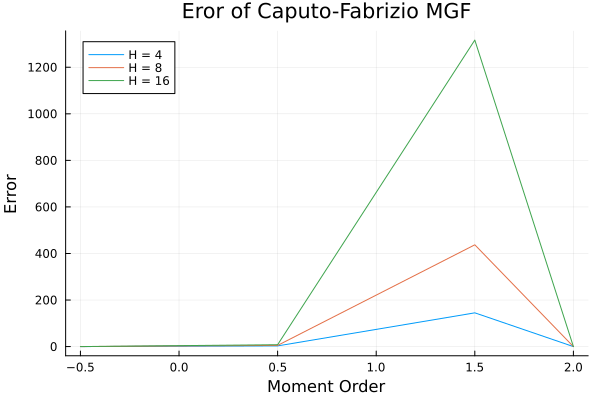

"c:\\Users\\jelle\\OneDrive\\Documenten\\GitHub\\Bachelor_Thesis\\latex_project\\figures\\conditional_moments_error.pdf"

In [7]:
#Plotting approximation error for different values of H and different orders
grouped = groupby(results_df, :H)

plt = plot(
    xlabel="Moment Order",
    ylabel="Error",
    title="Eror of Caputo-Fabrizio MGF",
    legend=:topleft,
    marker=:circle,
    linewidth=2
)

for g in grouped
    H = unique(g.H)[1]
    sort!(g, :order)
    differences = g.standard .- g.CF
    plot!(g.order, differences, label="H = $H")
end

display(plt)
savefig(plt, "latex_project/figures/conditional_moments_error.pdf")


In [28]:
#Computing fractional LPM
function fractional_LPM(dist::Distribution, order::Real, tau::Real=0)
    integrand(x) = (tau - x)^order * pdf(dist, x)
    integral, _ = quadgk(integrand, -Inf, tau)
    return integral
end

#Computing fractional LPM with Caputo-Fabrizio error
function fractional_LPM_CF(dist::Distribution, order::Real, tau::Real=0)
    n = floor(order)
    epsilon = 1e-10
    beta = order - n
    integrand(x) = (tau - x)^(n + 1) / ((1 - beta) * (tau - x) + beta + epsilon) * pdf(dist, x)
    integral, _ = quadgk(integrand, -Inf, tau)
    return integral
end

#Computing Value-at-Risk
function Value_at_Risk(dist::Distribution, confidence::Real)
    return quantile(dist, confidence)
end

Value_at_Risk (generic function with 1 method)

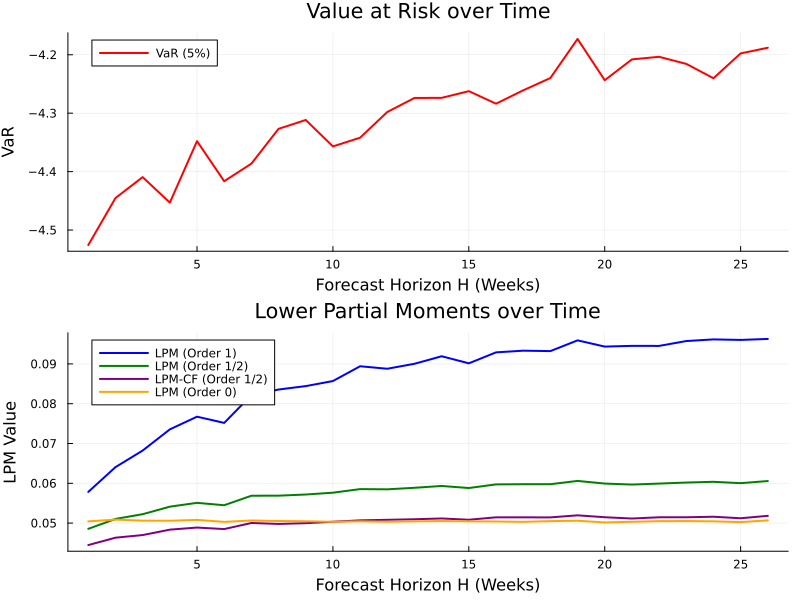

In [ ]:
#Defining time window interest (half a year)
H_values = 1:26

#Defining arrays for values we want to plot
VaR = zeros(length(H_values))
LPM_1 = zeros(length(H_values))
LPM_fractional = zeros(length(H_values))
LPM_fractional_CF = zeros(length(H_values))
LPM_0 = zeros(length(H_values))

#Calculating VaR and LPM for different orders
for (j, H) in enumerate(H_values)
    R_H = simulate_conditional_return(omega_hat, alpha_hat, beta_hat, H, 100_000)
    distribution_R = kde(R_H)
    pdf_R = FractionalMoments.KDEDistribution(distribution_R)
    tau = quantile(R_H, 0.05)
    VaR[j] = tau
    LPM_1[j] = fractional_LPM(pdf_R, 1, tau)
    LPM_fractional[j] = fractional_LPM(pdf_R, 0.5, tau)
    LPM_fractional_CF[j] = fractional_LPM_CF(pdf_R, 0.5, tau)
    LPM_0[j] = fractional_LPM(pdf_R, 0, tau)
end

#Plotting everything
plt = plot(layout=(2, 1), size=(800, 600))

plot!(plt[1], H_values, VaR, label="VaR (5%)", color=:red, lw=2)
xlabel!(plt[1], "Forecast Horizon H (Weeks)")
ylabel!(plt[1], "VaR")
title!(plt[1], "Value at Risk over Time")

plot!(plt[2], H_values, LPM_1, label="LPM (Order 1)", color=:blue, lw=2)
plot!(plt[2], H_values, LPM_fractional, label="LPM (Order 1/2)", color=:green, lw=2)
plot!(plt[2], H_values, LPM_fractional_CF, label="LPM-CF (Order 1/2)", color=:purple, lw=2)
plot!(plt[2], H_values, LPM_0, label="LPM (Order 0)", color=:orange, lw=2)
xlabel!(plt[2], "Forecast Horizon H (Weeks)")
ylabel!(plt[2], "LPM Value")
title!(plt[2], "Lower Partial Moments over Time")

display(plt)
#savefig(plt, "latex_project/figures/var_vs_lpm.pdf")


In [4]:
# Defining window of interest
H = 4
n = length(df_weekly.log_return)

#Defining window to obtain GARCH estimates to accurately obtain z-values
window = 520

x_all = abs.(df_weekly.log_return[1:(n-H)])
y_all = [mean(df_weekly.log_return[t+1:t+H] .^ 2) for t in 1:(n-H)]

x_raw = x_all[window:end]
y_raw = y_all[window:end]

#Standardizing data
x = (x_raw .- mean(x_raw)) ./ std(x_raw)
y = (y_raw .- mean(y_raw)) ./ std(y_raw)


#Initialising parameters of interest
alpha_initial = 0.2 / std(x .* y)
phi_initial = 0.9
omega_initial = (cov(x, y) / var(x)) * (1 - phi_initial)
sigma_2_initial = var(y)

#Ensuring parameters are non-negative
par_initial = vcat(omega_initial, log(phi_initial / (1 - phi_initial)), log(alpha_initial), log(sigma_2_initial))

#Obtaining loglikelihood values
function neg_llik_2(par)
    return -log_likelihood(y, x, par)
end

#Finding best likelihood value
result = optimize(neg_llik_2, par_initial, BFGS(), Optim.Options(iterations=10_000))
par_optimal = Optim.minimizer(result)

#Using link function to ensure that phi_hat < 1
omega_hat = par_optimal[1]
phi_hat = exp(par_optimal[2]) / (1 + exp(par_optimal[2]))
alpha_hat = exp(par_optimal[3])
sigma_2_hat = exp(par_optimal[4])
theta_hat = [omega_hat, phi_hat, alpha_hat, sigma_2_hat]
println(theta_hat)

[0.06645378588185623, 0.7804614768208831, 0.007112657069171009, 0.8392687720663576]


In [18]:
#Computing z took about 30 minutes (had to compute 100_000 * 520 * 4 integrals :D). 
#Values of z are stored such that we can import them when needed instead of having to calculate them again

Random.seed!(42)
#z_raw = compute_z(df_weekly.log_return, 0.5; H=2, n_sim=100_000, window=520, target_length=length(x))
#z = (z_raw .- mean(z_raw)) ./ std(z_raw)
df_z = CSV.read("data/z_data_var_2.csv", DataFrame)
z = df_z.z

#Initializing parameters of interest 
alpha_initial = 0.2 / std(z .* y)
phi_initial = 0.9
omega_initial = (cov(z, y) / var(z)) * (1 - phi_initial)
sigma_2_initial = var(y)

par_initial = vcat(omega_initial, log(phi_initial / (1 - phi_initial)), log(alpha_initial), log(sigma_2_initial))

#Obtaining loglikelihood values
function neg_llik_2(par)
    return -log_likelihood(y, z, par)
end

#Finding best loglikelihood value
result = optimize(neg_llik_2, par_initial, BFGS())
par_optimal = Optim.minimizer(result)

#Using link function to ensure phi_hat_z < 1
omega_hat_z = par_optimal[1]
phi_hat_z = exp(par_optimal[2]) / (1 + exp(par_optimal[2]))
alpha_hat_z = exp(par_optimal[3])
sigma_2_hat_z = exp(par_optimal[4])
theta_hat_z = [omega_hat_z, phi_hat_z, alpha_hat_z, sigma_2_hat_z]
println(theta_hat_z)

[0.07962547468398204, 0.8115860553869877, 0.218739700821416, 0.6830357302327227]


In [7]:
#df_z_var = DataFrame(z=z)
#CSV.write("data/z_data_var.csv", df_z_var)

df_z_var_2 = DataFrame(z=z)
CSV.write("data/z_data_var_2.csv", df_z_var_2)
display(z)

780-element Vector{Float64}:
  1.3976903595348456
  1.4801213786216638
  1.6615626054070767
  1.4342164042310308
  1.324252793373986
  1.1054235043282146
  1.2189488721596264
  1.0282259860161849
  0.8337376359832618
  0.3264954965134952
  0.15568240065301256
 -0.08118953659351631
  0.47859057705730423
  ⋮
  2.267416139337396
  1.9468886161376244
  1.872062492076274
  2.2545031374059783
  2.7145963098819066
  4.018506231536768
  4.331710793003282
  4.173966207653264
  4.492360450583297
  4.706477955638431
  4.500848678784815
  4.762400340077249

In [8]:
#Creating table containing parameter estimates of both models
results = DataFrame(
    Model=["Standard model", "Extended model"],
    omega_hat=[round.(theta_hat[1], digits=3), round.(theta_hat_z[1], digits=3)],
    phi_hat=[round.(theta_hat[2], digits=3), round.(theta_hat_z[2], digits=3)],
    alpha_hat=[round.(theta_hat[3], digits=3), round.(theta_hat_z[3], digits=3)],
    sigma_2_hat=[round.(theta_hat[4], digits=3), round.(theta_hat_z[4], digits=3)])
display(results)
save_latex_table(results, "Parameter estimates", "tables/observation_model")

Row,Model,omega_hat,phi_hat,alpha_hat,sigma_2_hat
,String,Float64,Float64,Float64,Float64
1,Standard model,0.066,0.78,0.007,0.839
2,Extended model,0.08,0.812,0.219,0.683


"c:\\Users\\jelle\\OneDrive\\Documenten\\GitHub\\Bachelor_Thesis\\latex_project\\tables/observation_model.tex"

In [9]:
#Obtaining time-variant betas for both models

beta = beta_path(x, y, theta_hat)
beta_z = beta_path(z, y, theta_hat_z)

780-element Vector{Float64}:
  0.4226092439576413
  0.2707203051959534
  0.2136175607079403
  0.11510813252064836
  0.11468570801643532
  0.07744198904037979
  0.06370739113012551
  0.10461819839802723
  0.13647412805373216
  0.12694306862585958
  0.16324105258672203
  0.1963677747139757
  0.24607063458018993
  ⋮
 -0.07477925391453871
 -0.12125327956992651
 -0.10501823135390281
 -0.08602835839729041
  0.14960701298670878
  0.06761583443105784
  0.09522065711531809
 -0.037273320882173194
 -0.0666874382936051
 -0.0556368572394416
 -0.05758022913571028
 -0.07368154938116174

In [ ]:
#Splitting dataset into training and testing set to obtain error measurements
split_index = Int(floor(0.8 .* length(y)))
x_train, y_train, z_train = x[1:split_index], y[1:split_index], z[1:split_index]
x_test, y_test, z_test = x[(split_index+1):end], y[(split_index+1):end], z[(split_index+1):end]

beta_x_test = beta[(split_index+1):end]
beta_z_test = beta_z[(split_index+1):end]

y_hat_x = beta_x_test .* x_test
y_hat_z = beta_z_test .* z_test

#println("AIC_x'", aic_x, "BIC_x", bic_x)
#println("AIC_z", aic_z, "BIC_z", bic_z)

#Obtaining MSE and MAE (and RMSE)
mse_x = mean(abs.(y_test - y_hat_x) .^ 2)
mse_z = mean(abs.(y_test - y_hat_z) .^ 2)
mae_x = mean(abs.(y_test - y_hat_x))
mae_z = mean(abs.(y_test - y_hat_z))


mean_y_test = mean(y_test)

#Obtaining R^2
n = length(y_test)

rss_x = n * (mse_x)
rss_z = n * (mse_z)

tss = sum((y_test .- mean_y_test) .^ 2)
r2_x = 1 - (rss_x / tss)
r2_z = 1 - (rss_z / tss)

#Storing results in table
results = DataFrame(
    Model=["Standard model", "Extended model"],
    MSE=[round.(mse_x, digits=3), round.(mse_z, digits=3)],
    MAE=[round.(mae_x, digits=3), round.(mae_z, digits=3)],
    RMSE=[round.(sqrt(mse_x), digits=3), round.(sqrt(mse_z), digits=3)],
    R2=[round.(r2_x, digits=3), round.(r2_z, digits=3)]
)
display(results)
#save_latex_table(results, "Performance measures", "tables/performance_measures")


Row,Model,MSE,MAE,RMSE,R2
,String,Float64,Float64,Float64,Float64
1,Standard model,0.275,0.387,0.524,0.023
2,Extended model,0.207,0.349,0.454,0.267


"c:\\Users\\jelle\\OneDrive\\Documenten\\GitHub\\Bachelor_Thesis\\latex_project\\tables/performance_measures.tex"

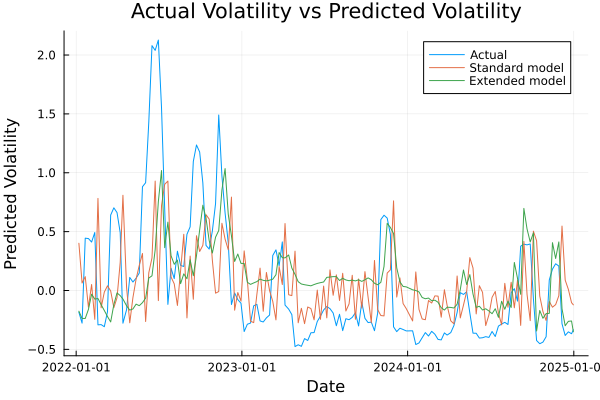

"c:\\Users\\jelle\\OneDrive\\Documenten\\GitHub\\Bachelor_Thesis\\latex_project\\figures\\predicting_volatility.pdf"

In [18]:
#Plotting actual volatility values against predictions
k = length(df_weekly.Date)
all_dates = df_weekly.Date[(k-n+1):end]
dates = all_dates[window:end]
dates_test = dates[(split_index+1):end]

plt = plot(all_dates, [y_test, y_hat_x, y_hat_z], xlabel="Date", ylabel="Predicted Volatility", label=["Actual" "Standard model" "Extended model"], title="Actual Volatility vs Predicted Volatility")
display(plt)
savefig(plt, "latex_project/figures/predicting_volatility.pdf")


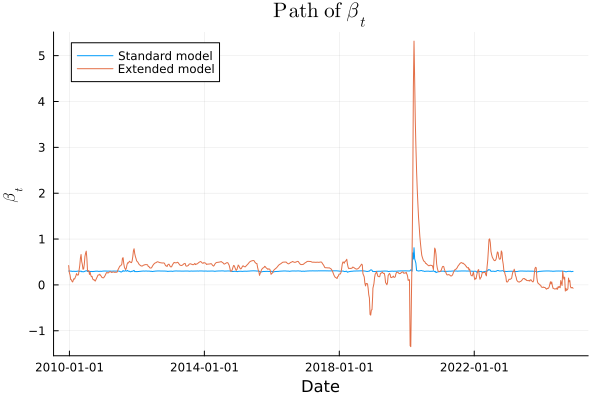

"c:\\Users\\jelle\\OneDrive\\Documenten\\GitHub\\Bachelor_Thesis\\latex_project\\figures\\beta_path_alternative.pdf"

In [12]:
#Plotting paths of beta for both models
plt = plot(df_weekly.Date[window:(end-H)], [beta, beta_z], xlabel="Date", ylabel=L"β_{t}", title=L"\mathrm{Path\ of\ } \beta_{t}", label=["Standard model" "Extended model"], legend=:topleft)
display(plt)
#savefig(plt, "latex_project/figures/beta_path.pdf")
savefig(plt, "latex_project/figures/beta_path_alternative.pdf")

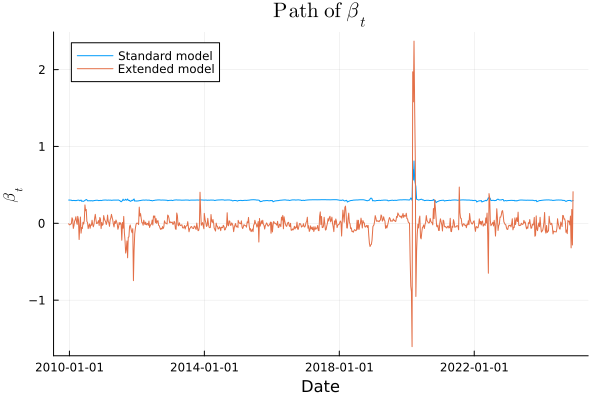

In [12]:
#Plotting paths of beta for both models
plt = plot(df_weekly.Date[window:(end-H)], [beta, beta_z], xlabel="Date", ylabel=L"β_{t}", title=L"\mathrm{Path\ of\ } \beta_{t}", label=["Standard model" "Extended model"], legend=:topleft)
display(plt)
#savefig(plt, "latex_project/figures/beta_path.pdf")
#savefig(plt, "latex_project/figures/beta_path_alternative.pdf")

In [ ]:
function simulate_conditional_variance(omega, alpha, beta, H, n_sim=100_000)
    sigma2_H = zeros(n_sim)
    sigma2_0 = omega / (1 - alpha - beta)

    for i in 1:n_sim
        sigma2 = sigma2_0
        for _ in 1:H
            epsilon = randn()
            sigma2 = omega + alpha * (sqrt(sigma2) * epsilon)^2 + beta * sigma2
        end
        sigma2_H[i] = sigma2
    end

    return sigma2_H
end


simulate_conditional_variance (generic function with 2 methods)

In [ ]:
#forecast_results, realized_volatility = forecast_power_fractional_moments(df_weekly.log_return)

#train_size = length(realized_volatility) - 200
#summary_table = DataFrame(gamma=Float64[],
    #beta_1=Float64[],
    #intercept=Float64[],
    #R2=Float64[],
    #MSE=Float64[]
#)

#gammas = [0.5, 1, 1.5, 2]

#for gamma in gammas
    #forecasts = forecast_results[gamma]
    #df = DataFrame(
        #forecast=forecasts,
        #volatility=realized_volatility
    #)

    #train_df = df[1:train_size, :]
    #test_df = df[(train_size+1):end, :]

    #model = lm(@formula(volatility ~ forecast), train_df)
    #prediction = predict(model, test_df)

    #mse = mean((prediction .- test_df.volatility) .^ 2)
    #R2 = r2(model)

    #coefficients = coef(model)
    #push!(summary_table, (gamma, coefficients[2], coefficients[1], R2, mse))
#end
#display(summary_table)

#forecast_dist = Normal(0, 0.02)
#VaR_5 = Value_at_Risk(forecast_dist, 0.05)
#println(VaR_5)
#LPM_1 = fractional_LPM(forecast_dist, 1.5)
#print(LPM_1)

#R_H = simulate_conditional_return(omega_hat, alpha_hat, beta_hat, 8, 20)
#distribution_R = kde(R_H)
#pdf_R = KDEDistribution(distribution_R)

#pdf_R

#LPM_2 = fractional_LPM(pdf_R, 1.5)
#println(LPM_2)

#tau = quantile(R_H, 0.05)
#println(tau)
#R_H

#LPM_1_CF = fractional_LPM_CF(forecast_dist, 1.5)
#println(LPM_1_CF)

#function simulate_cumulative_return(omega, alpha, beta, H, n_sim=100_000)
#R = zeros(n_sim)
#for i in 1:n_sim
#sigma_2 = zeros(H)
#r = zeros(H)
#sigma_2[1] = omega / (1 - alpha - beta)
#r[1] = rand(Normal(0, sqrt(sigma_2[1])))
#for t in 2:H
#sigma_2[t] = omega + alpha .* r[t-1] .^ 2 + beta .* sigma_2[t-1]
#r[t] = rand(Normal(0, sqrt(sigma_2[t])))
#end
#R[i] = sum(r)
#end
#return R
#end




#R = simulate_cumulative_return(omega_hat, alpha_hat, beta_hat, 24)
#distribution_R = kde(R)

#struct KDEDistribution <: Distributions.ContinuousUnivariateDistribution
    #kde::KernelDensity.UnivariateKDE
#end

#Distributions.pdf(d::KDEDistribution, x::Real) = pdf(d.kde, x)
#Base.minimum(d::KDEDistribution) = minimum(d.kde.x)
#Base.maximum(d::KDEDistribution) = maximum(d.kde.x)

#pdf_R = KDEDistribution(distribution_R)
#println(" standard: ", value, " CF: ", value_CF, " Simulated: ", empirical)

#Random.seed!(42)
#R_H = simulate_conditional_return(omega_hat, alpha_hat, beta_hat, 12, 1000)
#println(test)

#function forecast_volatility_moments(omega, alpha, beta, H_values, orders)
    #results = DataFrame(H=Int[], order=Float64[], empirical=Float64[], standard=Float64[], CF=Float64[])

    #for H in H_values
        #sigma_2_H = simulate_conditional_variance(omega, alpha, beta, H, 100)
        #distribution_sigma_2 = kde(sigma_2_H)
        #pdf_sigma_2 = KDEDistribution(distribution_sigma_2)

        #for order in orders      #Compute moments
            #empirical = empirical_fractional_moment(sigma_2_H, order)
            #standard = FractionalMoments.fractional_moment(pdf_sigma_2, order, use_abs=true)
            #CF = FractionalMoments.fractional_moment_CF(pdf_sigma_2, order, use_abs=true)
            #push!(results, (H, order, round.(empirical, digits=3), round.(standard, digits=3), round.(CF, digits=3)))


        #end
    #end
    #return results
#end